In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import shutil
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score

In [ ]:
# Define the path to your dataset
dataset_path = '/content/drive/My Drive/Laboratory'  # Adjust this path if necessary

# Create a function to prepare the data directories for ImageDataGenerator
def prepare_data_directories(dataset_path):
    base_dir = '/content/weapon_detection'
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'validation')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(validation_dir, exist_ok=True)

    for category in ['Positive', 'Negative']:
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(validation_dir, category), exist_ok=True)

    return base_dir, train_dir, validation_dir

# Prepare the data directories
base_dir, train_dir, validation_dir = prepare_data_directories(dataset_path)

# Split the dataset into training and validation sets
def split_dataset(dataset_path, train_dir, validation_dir, test_size=0.2):
    for category in ['Positive', 'Negative']:
        category_path = os.path.join(dataset_path, category)
        images = os.listdir(category_path)
        train_images, validation_images = train_test_split(images, test_size=test_size, random_state=42)

        for image in train_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(train_dir, category))

        for image in validation_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(validation_dir, category))

# Split the dataset
split_dataset(dataset_path, train_dir, validation_dir)

# Define ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Prepare data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

# Load the InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10)

# Evaluate the model
train_generator.reset()
validation_generator.reset()

train_loss, train_acc = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)
val_loss, val_acc = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)

print(f'Train accuracy: {train_acc}')
print(f'Validation accuracy: {val_acc}')

# Generate predictions
train_generator.reset()
validation_generator.reset()

train_predictions = model.predict(train_generator, steps=train_generator.samples // train_generator.batch_size)
validation_predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)

# Convert predictions to binary labels
train_predictions = (train_predictions > 0.5).astype(int)
validation_predictions = (validation_predictions > 0.5).astype(int)

# Get true labels
train_labels = train_generator.classes
validation_labels = validation_generator.classes

# Save predictions to a CSV file
train_df = pd.DataFrame({'Filename': train_generator.filenames, 'Prediction': train_predictions.flatten()})
validation_df = pd.DataFrame({'Filename': validation_generator.filenames, 'Prediction': validation_predictions.flatten()})

train_df.to_csv('train_predictions.csv', index=False)
validation_df.to_csv('validation_predictions.csv', index=False)

# Compute performance metrics
train_accuracy = accuracy_score(train_labels, train_predictions)
train_precision = precision_score(train_labels, train_predictions)
train_recall = recall_score(train_labels, train_predictions)
train_classification_report = classification_report(train_labels, train_predictions)

validation_accuracy = accuracy_score(validation_labels, validation_predictions)
validation_precision = precision_score(validation_labels, validation_predictions)
validation_recall = recall_score(validation_labels, validation_predictions)
validation_classification_report = classification_report(validation_labels, validation_predictions)

print(f'Train Accuracy: {train_accuracy}')
print(f'Train Precision: {train_precision}')
print(f'Train Recall: {train_recall}')
print(f'Train Classification Report:\n{train_classification_report}')

print(f'Validation Accuracy: {validation_accuracy}')
print(f'Validation Precision: {validation_precision}')
print(f'Validation Recall: {validation_recall}')
print(f'Validation Classification Report:\n{validation_classification_report}')

# Download the CSV files
from google.colab import files
files.download('train_predictions.csv')
files.download('validation_predictions.csv')


Found 384 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/10
12/12 [==============================] - 56s 4s/step - loss: 10.7936 - accuracy: 0.8385 - val_loss: 12.6632 - val_accuracy: 0.5000
Epoch 2/10
12/12 [==============================] - 44s 4s/step - loss: 0.2172 - accuracy: 0.9948 - val_loss: 4.9218 - val_accuracy: 0.4792
Epoch 3/10
12/12 [==============================] - 45s 4s/step - loss: 1.3504e-29 - accuracy: 1.0000 - val_loss: 9.1173 - val_accuracy: 0.5000
Epoch 4/10
12/12 [==============================] - 46s 4s/step - loss: 8.5588e-22 - accuracy: 1.0000 - val_loss: 10.5218 - val_accuracy: 0.5000
Epoch 5/10
12/12 [==============================] - 45s 4s/step - loss: 2.7457e-13 - accuracy: 1.0000 - val_loss: 10.9722 - val_accuracy: 0.5000
Epoch 6/10
12/12 [==============================] - 41s 3s/step - loss: 1.1829e-13 - accuracy: 1.0000 - val_loss: 11.1133 - val_accuracy: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

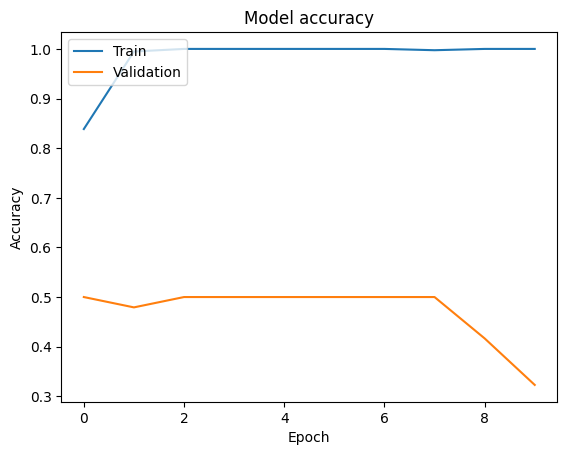

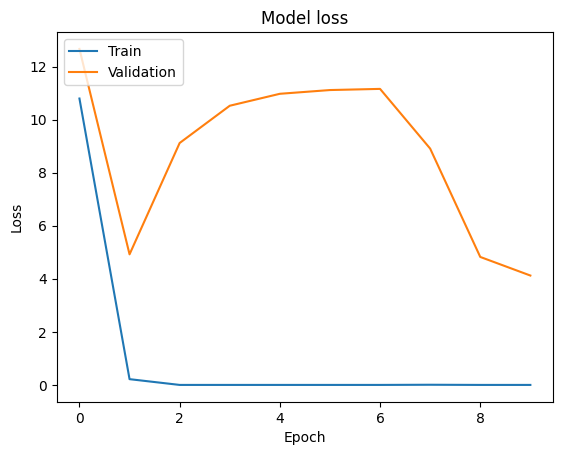

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


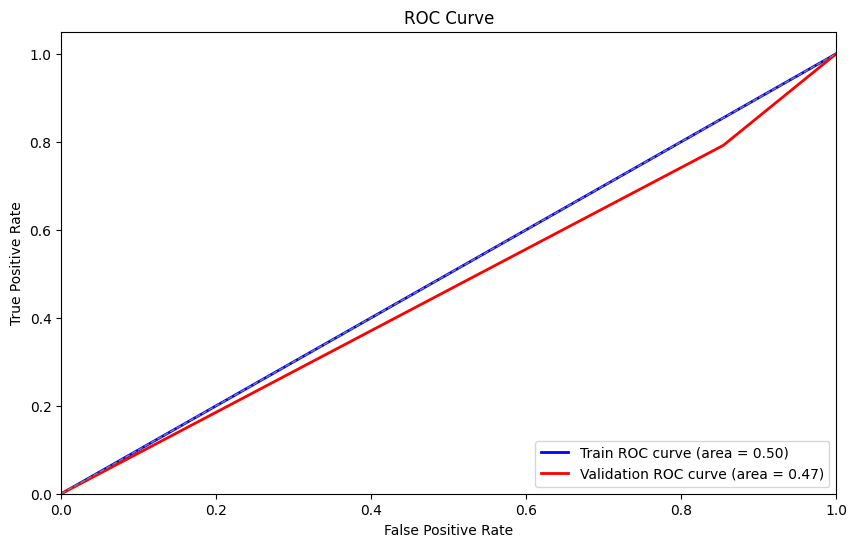

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
train_fpr, train_tpr, train_thresholds = roc_curve(train_labels, train_predictions)
train_roc_auc = auc(train_fpr, train_tpr)

validation_fpr, validation_tpr, validation_thresholds = roc_curve(validation_labels, validation_predictions)
validation_roc_auc = auc(validation_fpr, validation_tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label='Train ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot(validation_fpr, validation_tpr, color='red', lw=2, label='Validation ROC curve (area = %0.2f)' % validation_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
